# DQN Plots

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import subprocess
import os

%matplotlib inline

In [2]:
results_url = "https://openaisciszymon.blob.core.windows.net/dqn-blogpost/results.pkl"
download_path = "dqn_results.pkl"
if not os.path.exists(download_path):
    process = subprocess.Popen(["wget", results_url, "-O", download_path], 
                               stdout=subprocess.PIPE, 
                               stderr=subprocess.STDOUT,
                               universal_newlines=True)
    for line in process.stdout:
        print("\r" + line.strip(), end='', flush=True)
with open(download_path, "rb") as f:
    run_to_episode_data = pickle.load(f)

In [3]:
def subsample(t, vt, bins):
    """Given a data such that value vt[i] was observed at time t[i],
    group it into bins: (bins[j], bins[j+1]) such that values
    for bin j is equal to average of all vt[k], such that 
    bin[j] <= t[k] < bin[j+1].
    
    Parameters
    ----------
    t: np.array
        times at which the values are observed
    vt: np.array
        values for those times
    bins: np.array
        endpoints of the bins.
        for n bins it shall be of length n + 1.
    
    Returns
    -------
    x: np.array
        endspoints of all the bins
    y: np.array
        average values in all bins"""
    bin_idx = np.digitize(t, bins) - 1
    v_sums = np.zeros(len(bins) - 1, dtype=np.float32)
    v_cnts = np.zeros(len(bins) - 1, dtype=np.float32)
    np.add.at(v_sums, bin_idx, vt)
    np.add.at(v_cnts, bin_idx, 1)
    
    # ensure graph has no holes
    zs = np.where(v_cnts == 0)
    assert v_cnts[0] > 0
    for zero_idx in zs:
        v_sums[zero_idx] = v_sums[zero_idx - 1]
        v_cnts[zero_idx] = v_cnts[zero_idx - 1]

    return bins[1:], v_sums / v_cnts

In [4]:
from collections import defaultdict

experiment_to_name = {
    'atari-a': "Double Q learning",
    'atari-duel-a' : "Dueling Double Q learning", 
    'atari-prior-a': "Double Q learning with Prioritized Replay",
    'atari-prior-duel-a' : "Dueling Double Q learning with Prioritized Replay", 
    'atari-rb100-test': "Double Q learning with Replay buffer size = 100",
    'atari-rb10000-test': "Double Q learning with Replay buffer size = 10000",
    'atari-rb100000-test': "Double Q learning with Replay buffer size = 100000",
}

MAX_TSTEPS = int(2e8)

experiments = sorted(experiment_to_name.keys())
                                    
game_data = defaultdict(lambda: defaultdict(lambda: []))
for run_name, data in run_to_episode_data.items():
    for experiment in experiments:
        if run_name.startswith(experiment):
            game = data['env_id'][:-len('NoFrameskip-v3')]
            t = np.cumsum(data['episode_data']["episode_lengths"])
            r = np.array(data['episode_data']["episode_rewards"])
            # Ensure all mesurements after the deadline of 2e8 are thrown away
            t_fltr, r_fltr = t[t < MAX_TSTEPS], r[t < MAX_TSTEPS]
            game_data[game][experiment].append((t_fltr, r_fltr))
            break

In [5]:
def episode_data_to_plot_data(episode_data):
    """Given data from multiple episodes make it such that it can be plotted
    by tsplot, i.e. the mean + confidence bounds."""
    times, units, values = [], [], []
    for i, (ep_len, ep_rew) in enumerate(episode_data):
        # Smooth out the data
        ep_rew = pd.Series(ep_rew).ewm(span=1000).mean()
        
        # Subsample for faster plotting
        NSAMPLES = 1000
        x, y = subsample(t=ep_len, vt=ep_rew, bins=np.linspace(0, MAX_TSTEPS, NSAMPLES + 1))
        
        # Convert to tsplot format.
        times.extend(x)
        values.extend(y)
        units.extend([i] * len(x))

    return pd.DataFrame({'Frame': times, 'run_id': units, 'Average Episode Reward': values})

In [6]:
def plot_experiments(experiments_to_plot, ncols=4):
    colors = ['red', 'green', 'blue', 'yellow', 'magenta', 'cyan']
    assert len(colors) >= len(experiments_to_plot)
    pref_to_color = dict(zip(experiments_to_plot, colors))
    
    # Print out the legent.
    for experiment, color in pref_to_color.items():
        print(color, ":", experiment_to_name[experiment])
    
    # Select relevant games for those experiments.
    all_games = list(game_data.keys())
    relevevant_games = [g for g in all_games 
                        if any(e in game_data[g] for e in experiments_to_plot)]
    
    # Create the figure.
    ncols = min(ncols, len(relevevant_games))
    nrows = (len(relevevant_games) + ncols - 1) // ncols
    f, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
    if nrows == 1:
        axes = [axes]

    # Plot the data.
    for i, game in enumerate(sorted(relevevant_games)):
        ax = axes[i // ncols][i % ncols]
        ax.set_title(game)
        for experiment, experiment_data in game_data[game].items():
            if experiment not in experiments_to_plot:
                continue

            sns.tsplot(data=episode_data_to_plot_data(experiment_data),
                       time="Frame", value="Average Episode Reward", unit="run_id", 
                       ci=[68, 95], ax=ax, color=pref_to_color[experiment])

## Effect of buffer size

green : Double Q learning with Replay buffer size = 10000
blue : Double Q learning with Replay buffer size = 100000
red : Double Q learning with Replay buffer size = 100


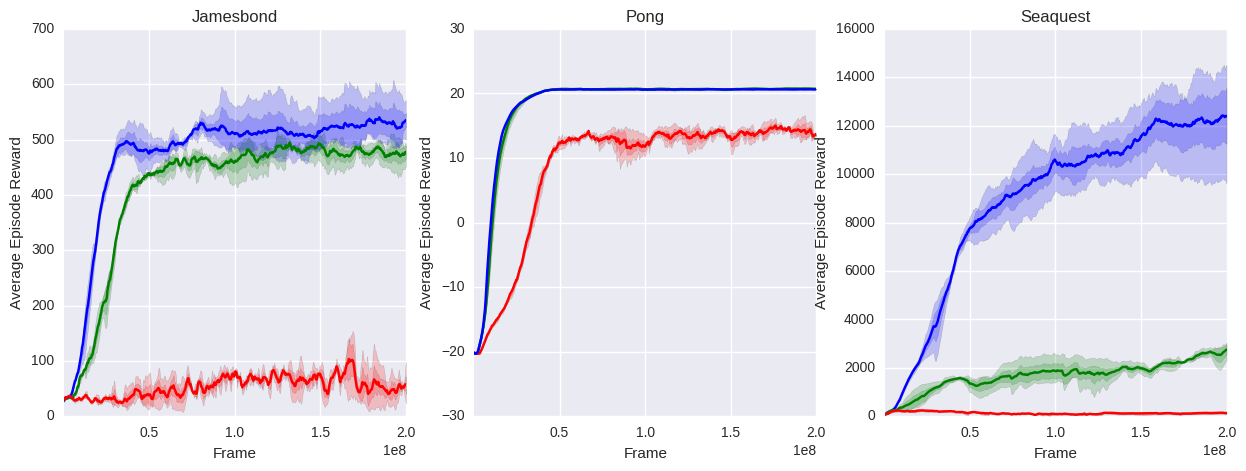

In [7]:
plot_experiments(['atari-rb100-test', 'atari-rb10000-test', 'atari-rb100000-test'])

## Larger benchmark

blue : Double Q learning with Prioritized Replay
green : Dueling Double Q learning
red : Double Q learning
yellow : Dueling Double Q learning with Prioritized Replay


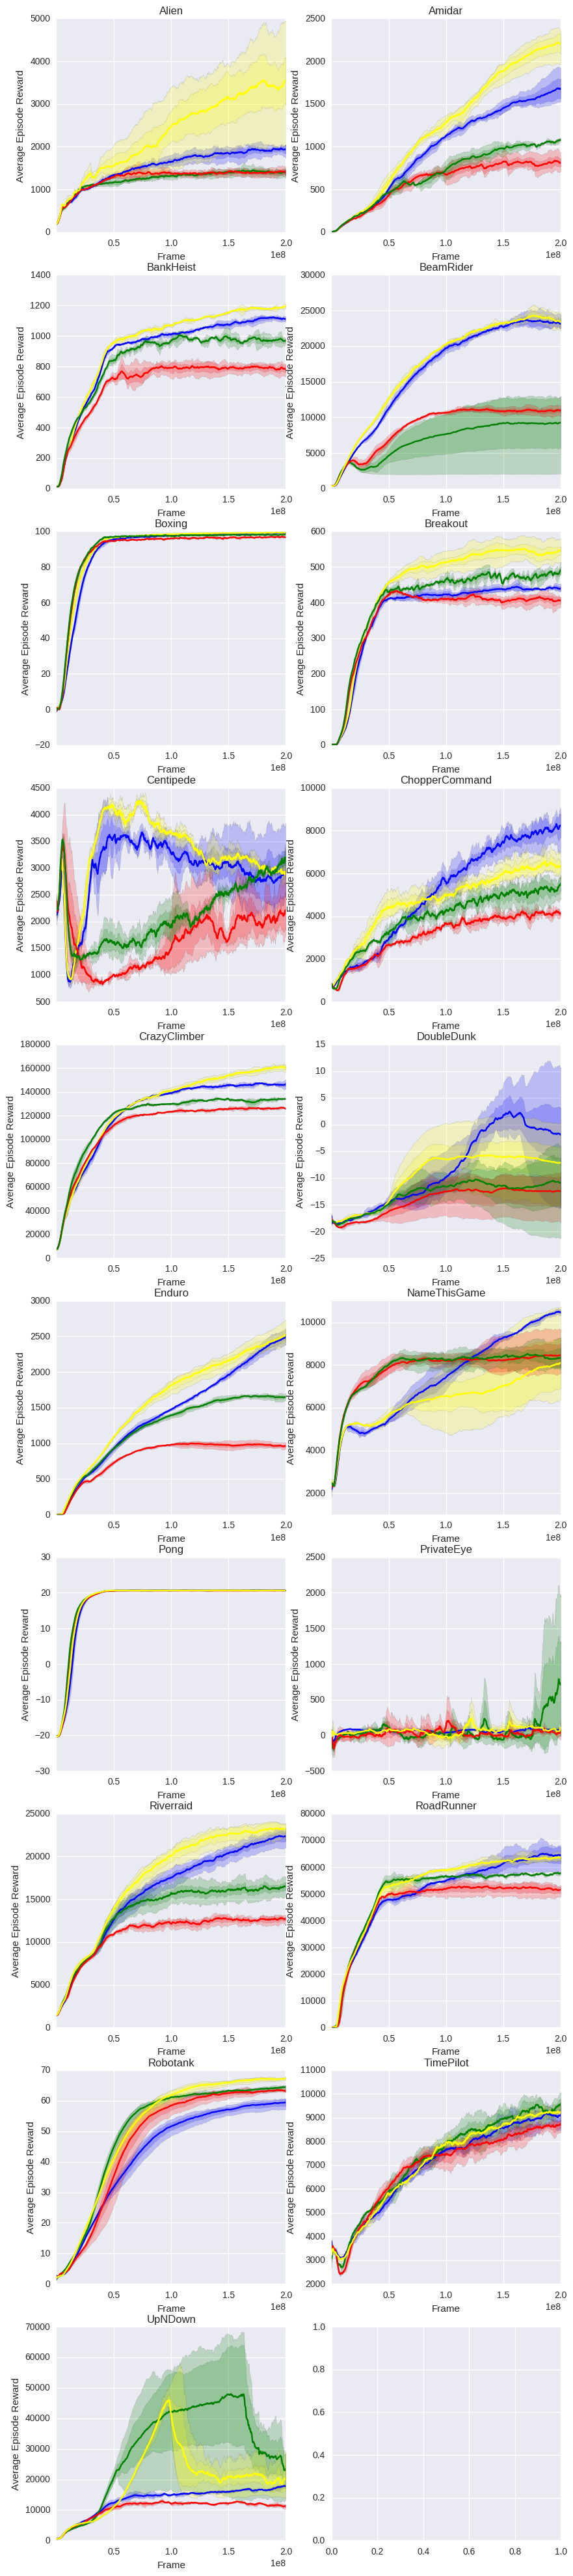

In [8]:
exp = ['atari-a', 'atari-duel-a', 'atari-prior-a', 'atari-prior-duel-a']
plot_experiments(exp, ncols=2)

## Performance at the end of training.

We compare our results to the "Dueling Network Architectures for Deep Reinforcement Learning" paper. 

Despite our best efforts we are unsure about the specific setup for evaluating the algorithms. Specifically, we are unsure about the following factors:
- Is the policy used for the evaluation the result of choosing average or max across random seeds? We report both.
- Is the policy selected from the end of the training or is it the best performing policy across the entire training time? We use the former.
- How long are the evaluation episodes for the 30 No-op scenario? We use 108, 000 frames.

Note that the Atari game implementations used by us and the authors are different, so there might be subtle differences. We use the ones from OpenAI gym.

Due to all the factors above we propose an alternative simpler metric - **mean reward across entire training period**. We recommend reporting mean and standard deviation across random seeds and present the results for it below.

### Wang et al., 2015 evaluation

In [9]:
# Source: https://arxiv.org/pdf/1511.06581v3.pdf
reported_scores_30noop = {
    'Alien': 3941.0,
    'Amidar': 2296.8,
    'BankHeist': 1503.1,
    'BeamRider': 30276.5,
    'Boxing': 98.9,
    'Breakout': 366.0,
    'Centipede': 7687.5,
    'ChopperCommand': 13185.0,
    'CrazyClimber': 162224.0,
    'DoubleDunk': -12.5,
    'Enduro': 2306.4,
    'NameThisGame': 15572.5,
    'Pong': 20.9,
    'PrivateEye': 206.0,
    'Riverraid': 20607.6,
    'RoadRunner': 62151.0,
    'Robotank': 27.5,
    'TimePilot': 7553.0,
    'UpNDown': 33879.1,
}

# generated using wang2015_eval.py in atari experiments folder.
our_scores_30noop = {
    'Alien': [4341.7, 5155.3, 2020.3],
    'Amidar': [2100.9, 2578.7, 2195.0],
    'BankHeist': [1119.3, 1132.3, 1177.0],
    'BeamRider': [24697.8, 32312.7, 29142.1],
    'Boxing': [99.7, 99.7, 99.2],
    'Breakout': [592.0, 602.0, 495.0],
    'Centipede': [2606.7, 3155.9, 2626.8],
    'ChopperCommand': [5890.0, 5246.7, 6746.7],
    'CrazyClimber': [169596.7, 157486.7, 152743.3],
    'DoubleDunk': [0.1, -21.2, -7.3],
    'Enduro': [2014.5, 2039.4, 2055.3],
    'NameThisGame': [5983.3, 7838.7, 11288.7],
    'Pong': [20.8, 20.8, 20.7],
    'PrivateEye': [912.2, 66.7, 100.0],
    'Riverraid':  [22158.7, 21392.7, 23136.7],
    'RoadRunner': [64846.7, 59663.3, 62470.0],
    'Robotank': [66.7, 64.9, 67.1],
    'TimePilot': [5890.0, 6633.3, 6593.3],
    'UpNDown': [12643.3, 23107.3, 11753.3],
}

In [11]:
print("Score               Wang et al., 2015   Ours (+/- std)              Ours (best of 3)")
print()
for game in sorted(reported_scores_30noop.keys()):
    means = our_scores_30noop[game]
    res = ''
    for thing, desired_len in [
            (game, 20),
            (reported_scores_30noop[game], 20),
            (np.round(np.mean(means), 1), 9),
            ("+/-", 4),
            (np.round(np.std(means) / np.sqrt(len(means)), 1), 15),
            (np.max(means), 8),
        ]:
        res += str(thing) + ' ' * (desired_len - len(str(thing)))
    print(res)


Score               Wang et al., 2015   Ours (+/- std)              Ours (best of 3)

Alien               3941.0              3839.1   +/- 766.9          5155.3  
Amidar              2296.8              2291.5   +/- 119.3          2578.7  
BankHeist           1503.1              1142.9   +/- 14.3           1177.0  
BeamRider           30276.5             28717.5  +/- 1803.2         32312.7 
Boxing              98.9                99.5     +/- 0.1            99.7    
Breakout            366.0               563.0    +/- 27.9           602.0   
Centipede           7687.5              2796.5   +/- 146.8          3155.9  
ChopperCommand      13185.0             5961.1   +/- 354.7          6746.7  
CrazyClimber        162224.0            159942.2 +/- 4096.9         169596.7
DoubleDunk          -12.5               -9.5     +/- 5.1            0.1     
Enduro              2306.4              2036.4   +/- 9.7            2055.3  
NameThisGame        15572.5             8370.2   +/- 1269.2        

### OpenAI evaluation

In [12]:
print("Score                Ours (+/- std)")
print()
for game in sorted(reported_scores_30noop.keys()):
    means = [np.mean(d[1]) for d in game_data[game]['atari-prior-duel-a']]
    res = ''
    for thing, desired_len in [
            (game, 20),
            (np.round(np.mean(means), 1), 9),
            ("+/-", 4),
            (np.round(np.std(means) / np.sqrt(len(means)), 1), 15),
        ]:
        res += str(thing) + ' ' * (desired_len - len(str(thing)))
    print(res)

Score                Ours (+/- std)

Alien               2086.3   +/- 296.8          
Amidar              1002.1   +/- 33.3           
BankHeist           898.1    +/- 1.9            
BeamRider           15993.5  +/- 86.6           
Boxing              95.7     +/- 0.2            
Breakout            258.7    +/- 1.3            
Centipede           3156.5   +/- 27.4           
ChopperCommand      4910.8   +/- 213.6          
CrazyClimber        129963.1 +/- 588.5          
DoubleDunk          -10.2    +/- 2.1            
Enduro              1595.6   +/- 36.5           
NameThisGame        6393.6   +/- 533.7          
Pong                19.0     +/- 0.0            
PrivateEye          67.9     +/- 20.3           
Riverraid           15989.7  +/- 287.2          
RoadRunner          44535.8  +/- 860.2          
Robotank            49.5     +/- 0.5            
TimePilot           7060.6   +/- 57.2           
UpNDown             15059.6  +/- 910.4          
